<a href="https://colab.research.google.com/github/sudehashrafi/alzheimerClassification_MRI_dataset/blob/main/3classDataset_alz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fabrizioravelli/3-class-alzheimer-disease

 83% 96.0M/116M [00:00<00:00, 229MB/s]
100% 116M/116M [00:00<00:00, 222MB/s] 


In [ ]:
!unzip 3-class-alzheimer-disease.zip

Streaming output truncated to the last 5000 lines.
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (976).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (977).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (978).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (979).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (980).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (981).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (982).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (983).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (984).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (985).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (986).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (987).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (988).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (989).jpg  
  inflating: 3_CLASS/train/MILD_DEMENTED/TRAIN_MILD (

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

!pip install pandas_profiling==3.1.0
from pandas_profiling import ProfileReport

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import pathlib
import os
import cv2
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras import models
from keras import layers
from keras.layers import Dense,  Activation , Dropout , Flatten , Conv2D , MaxPooling2D
from skimage.transform import resize
from keras.utils import np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 6.6 MB/s 
     |████████████████████████████████| 303 kB 60.1 MB/s 
     |████████████████████████████████| 3.1 MB 71.3 MB/s 
     |████████████████████████████████| 690 kB 72.5 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
     |████████████████████████████████| 102 kB 12.9 MB/s 
     |████████████████████████████████| 812 kB 68.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=c6b7855f3d6545b1171de8701a217c519474c43c70af064e78a8667a8d222dd9
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=a38aa1badf274cdb68ae7508ff

In [ ]:
base_dir_train = '/content/3_CLASS/train/'
base_dir_test = '/content/3_CLASS/test/'

labels = ['MILD_DEMENTED', 'NON_DEMENTED' , 'VERYMILD_DEMENTED']

img_size = 50

In [ ]:
def rename(path):

  for count, filename in enumerate(os.listdir(path)):
      dst = f"{str(count)}.jpg"
      src =f"{path}/{filename}"  # foldername/filename, if .py file is outside folder
      dst =f"{path}/{dst}"
      # rename() function will
      # rename all the files
      os.rename(src, dst)

In [ ]:
for i in labels : 
  path = base_dir_train + i +'/'
  rename(path)
  path = base_dir_test + i + '/'
  rename(path)

In [ ]:
def preproccessing(base_dir_train = '/content/3_CLASS/train/' , 
                   base_dir_test = '/content/3_CLASS/test/' , 
                   labels = ['MILD_DEMENTED', 'NON_DEMENTED' , 'VERYMILD_DEMENTED']):
  
  dataset_train = []
  dataset_test = []

#train
  for i in range(len(labels)):
    path_train = base_dir_train + labels[i]
    img_count = 0 
    for base, dirs, files in os.walk(path_train):
      print('Searching in : ', base)
      for Files in files:
          img_count += 1
    for j in range(img_count):
      img = np.array(cv2.imread(path_train  +'/' + str(j) + '.jpg' , 0))
      # print(img)
      try:
        img = resize(img , (img_size , img_size))
        img = img.reshape(img_size ** 2)
        # print(img)
        #in grayscale, numbers are between 0 to 255 , so in order to normalize my data
        # i devide each image by 255.0 so all of them will become between 0 to 1
        img = img/255.00
        dataset_train.append([img , i])
      except:
        pass
#test
  for i in range(len(labels)):
    path_test = base_dir_test + labels[i]
    img_count = 0 
    for base, dirs, files in os.walk(path_test):
      print('Searching in : ', base)
      for Files in files:
          img_count += 1
    for j in range(img_count):
      img = np.array(cv2.imread(path_test  +'/' + str(j) + '.jpg' , 0))
      try:
        img = resize(img , (img_size , img_size))
        img = img.reshape(img_size ** 2)
        #in grayscale, numbers are between 0 to 255 , so in order to normalize my data
        # i devide each image by 255.0 so all of them will become between 0 to 1
        img = img/255.00
        dataset_test.append([img , i])
      except:
        pass


  dataset_train = np.array(dataset_train)
  dataset_test = np.array(dataset_test)  
  # print(dataset_train)
  y_train = keras.utils.np_utils.to_categorical(dataset_train[:,1], num_classes=3)
  y_test = keras.utils.np_utils.to_categorical(dataset_test[:,1], num_classes=3)

  x_train = dataset_train[:,0]
  x_test = dataset_test[:,0]

  return  x_train , y_train , x_test , y_test

In [ ]:
x_train , y_train , x_test , y_test  = preproccessing()

Searching in :  /content/3_CLASS/train/MILD_DEMENTED
Searching in :  /content/3_CLASS/train/NON_DEMENTED
Searching in :  /content/3_CLASS/train/VERYMILD_DEMENTED
Searching in :  /content/3_CLASS/test/MILD_DEMENTED
Searching in :  /content/3_CLASS/test/NON_DEMENTED
Searching in :  /content/3_CLASS/test/VERYMILD_DEMENTED


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
x_train.shape , y_train.shape

((5697,), (5697, 3))

In [ ]:
x_test.shape , y_test.shape

((633,), (633, 3))

In [ ]:
def reshaping(x_dataset) : 
  temp2 = []
  for i in x_dataset:
    temp = []
    for j in i:
      temp.append(j)
    temp2.append(temp)

  x_dataset = np.array(temp2)

  return x_dataset

In [ ]:
x_test = reshaping(x_test)
x_train = reshaping(x_train)

In [ ]:
x_train.shape

(5697, 2500)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential()

model.add(Dense(64, activation='relu', input_dim=img_size ** 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                160064    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          epochs=100,
          batch_size=32 , validation_split=0.2)

Epoch 1/100
143/143 [==============================] - 5s 8ms/step - loss: 1.1930 - accuracy: 0.5640 - val_loss: 1.1880 - val_accuracy: 0.0000e+00
Epoch 2/100
143/143 [==============================] - 1s 6ms/step - loss: 0.8727 - accuracy: 0.6542 - val_loss: 1.2815 - val_accuracy: 0.0000e+00
Epoch 3/100
143/143 [==============================] - 1s 7ms/step - loss: 0.7573 - accuracy: 0.6860 - val_loss: 0.9194 - val_accuracy: 0.0000e+00
Epoch 4/100
143/143 [==============================] - 1s 7ms/step - loss: 0.7234 - accuracy: 0.7079 - val_loss: 1.3754 - val_accuracy: 0.0000e+00
Epoch 5/100
143/143 [==============================] - 1s 7ms/step - loss: 0.6694 - accuracy: 0.7220 - val_loss: 2.0350 - val_accuracy: 0.0026
Epoch 6/100
143/143 [==============================] - 1s 6ms/step - loss: 0.6299 - accuracy: 0.7419 - val_loss: 1.5607 - val_accuracy: 0.1789
Epoch 7/100
143/143 [==============================] - 1s 6ms/step - loss: 0.5864 - accuracy: 0.7520 - val_loss: 1.8348 - val_

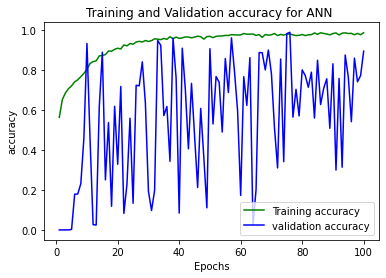

In [ ]:
%matplotlib inline
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy for ANN ')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print('\nTesting loss: %.2f, acc: %.2f%%'%(loss, acc))

20/20 [==============================] - 0s 3ms/step - loss: 0.8663 - accuracy: 0.8152

Testing loss: 0.87, acc: 0.82%


In [ ]:
x_train = x_train.reshape(-1,50,50 , 1)
x_test = x_test.reshape(-1,50,50 , 1)
x_train.shape , x_test.shape

((5697, 50, 50, 1), (633, 50, 50, 1))

In [ ]:
model = Sequential()

model.add(Conv2D(64 ,kernel_size=(3,3) , activation='relu' , input_shape = (img_size,img_size,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3) , activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128  , kernel_size=(3,3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128  , kernel_size=(3,3) , activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(256))

model.add(Dense(3 , activation='softmax'))

In [ ]:
model.compile(optimizer='adam' , loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train , y_train  ,  batch_size=32 , epochs = 50 , validation_split= 0.1 )

Epoch 1/50
161/161 [==============================] - 12s 12ms/step - loss: 0.9145 - accuracy: 0.5875 - val_loss: 1.1665 - val_accuracy: 0.0000e+00
Epoch 2/50
161/161 [==============================] - 1s 8ms/step - loss: 0.7887 - accuracy: 0.6154 - val_loss: 1.1924 - val_accuracy: 0.0000e+00
Epoch 3/50
161/161 [==============================] - 1s 8ms/step - loss: 0.7611 - accuracy: 0.6296 - val_loss: 1.3414 - val_accuracy: 0.0000e+00
Epoch 4/50
161/161 [==============================] - 1s 8ms/step - loss: 0.7216 - accuracy: 0.6394 - val_loss: 0.9279 - val_accuracy: 0.7175
Epoch 5/50
161/161 [==============================] - 1s 8ms/step - loss: 0.6976 - accuracy: 0.6546 - val_loss: 1.3250 - val_accuracy: 0.2702
Epoch 6/50
161/161 [==============================] - 1s 8ms/step - loss: 0.6671 - accuracy: 0.6733 - val_loss: 2.2061 - val_accuracy: 0.0632
Epoch 7/50
161/161 [==============================] - 1s 8ms/step - loss: 0.6358 - accuracy: 0.6914 - val_loss: 1.1445 - val_accuracy:

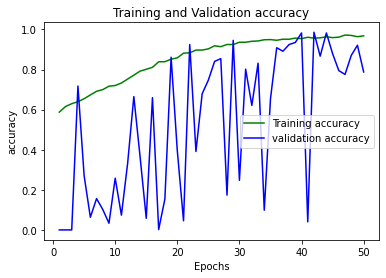

In [ ]:
%matplotlib inline
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test , verbose=2)
print('\nTesting loss: %.2f, acc: %.2f%%'%(test_loss, test_acc))

20/20 - 0s - loss: 0.4672 - accuracy: 0.8420 - 233ms/epoch - 12ms/step

Testing loss: 0.47, acc: 0.84%
